In [55]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import openml
from scipy.stats import wilcoxon
from sklearn.metrics import zero_one_loss
%matplotlib inline

In [2]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )

In [3]:
clfs = ['RF', 'IRF', 'SigRF', 'UF']
color_dict = {
    'UF': '#e41a1c',
    'RF': '#377eb8',
    'SigRF': '#4daf4a',
    'IRF': '#984ea3',
}

In [4]:
def get_task_scores(score_fn, results_dir='./results_cv10/'):
    tasks = []
    task_score_means = []
    task_score_stds = []
    for file in os.listdir(results_dir):
        with open(results_dir + file, 'rb') as f:
            results_dict = pickle.load(f)

        score_means = [
            np.mean([
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ]) for name in clfs
        ]

        score_stds = [
            np.std([
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ]) for name in clfs
        ]
        
        tasks.append(
            {k: results_dict[k] for k in ['task_id', 'task', 'n_samples', 'n_classes', 'n_features']
            })
        task_score_means.append(score_means)
        task_score_stds.append(score_stds)

    return tasks, task_score_means, task_score_stds

## CSVs

### Brier

In [5]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [6]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [8]:
score_df.to_csv('./figures/brier_scores_cv10.csv')

### ECE

In [9]:
tasks, task_score_means, task_score_stds = get_task_scores(ece)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [10]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [12]:
score_df.to_csv('./figures/ece_scores_cv10.csv')

### MCE

In [13]:
tasks, task_score_means, task_score_stds = get_task_scores(mce)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [14]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [15]:
score_df.to_csv('./figures/mce_scores_cv10.csv')

# Plots

In [5]:
import seaborn as sns

In [6]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind, scale='log'):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    vmin = min(np.min([df[hue]]), 0)
    vmax = max(np.max([df[hue]]), 0)
    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(
            # The effort I put into figuring this out.....
            c=df[hue], cmap=cmap, norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
        ),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r , c].set_xscale(scale)
                if r != c:
                    g.axes[c , r].set_yscale(scale)
    
    sm = mpl.cm.ScalarMappable(
        mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax),
        cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    return g

## Brier Score

In [16]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

## Testing for performance boost

In [56]:
from collections import defaultdict
from scipy.stats import spearmanr

In [57]:
df = score_df.sort_values('UF_reldiff_RF', ascending=False)[['Dataset', 'n_classes', 'n_features', 'RF', 'UF', 'UF_reldiff_RF']]

In [58]:
task_ids = np.asarray(df.index)
target_vals = defaultdict(list)

dataset_attrs = defaultdict(list)
for task_id in task_ids:
    task = openml.tasks.get_task(task_id)
    for key, val in task.get_dataset().qualities.items():
        dataset_attrs[key].append(val)
        target_vals[key].append(df.loc[task_id]['UF_reldiff_RF'])

In [59]:
target = df
corrs = []
attrs = []
pvals = []
for key, val in dataset_attrs.items():
    val = np.asarray(val)
    if any(np.isnan(val)):
        continue
    else:
        corr, pval = spearmanr(val, target_vals[key])
        corrs.append(corr)
        attrs.append(key)
        pvals.append(pval)

In [60]:
stats_corr_df = pd.DataFrame(data=np.asarray([attrs, corrs, pvals]).T, columns=['Dataset_attribute', 'spearmanr', 'pvalue'])

In [61]:
with pd.option_context("display.max_rows", 1000):
    display(stats_corr_df)

,Dataset_attribute,spearmanr,pvalue
0,AutoCorrelation,-0.04508041716997378,0.7171732999459013
1,ClassEntropy,-0.07450805044778074,0.5490186426777612
2,Dimensionality,0.18816534807392674,0.12729118388408003
3,MajorityClassPercentage,0.038008195730500835,0.7600873605946846
4,MajorityClassSize,-0.0425432077834962,0.7324768461994797
5,MaxNominalAttDistinctValues,-0.20379200525504246,0.09810183098056365
6,MeanNominalAttDistinctValues,-0.2017107178920078,0.10165659335866423
7,MinNominalAttDistinctValues,-0.15317603225158127,0.21589302354817172
8,MinorityClassPercentage,0.17725504158679034,0.15129238391020142
9,MinorityClassSize,-0.061823855295979877,0.6191872239394891


In [9]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv('./csvs/brier_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,1476.500 (0.983),1101.000 (0.406),1180.500 (0.602)
IRF,801.500 (0.017),,537.500 (0.000),767.500 (0.010)
SigRF,1177.000 (0.594),1740.500 (1.000),,995.000 (0.184)
UF,1097.500 (0.398),1510.500 (0.990),1283.000 (0.816),


In [21]:
sns.set_context("paper", font_scale=1.5)   

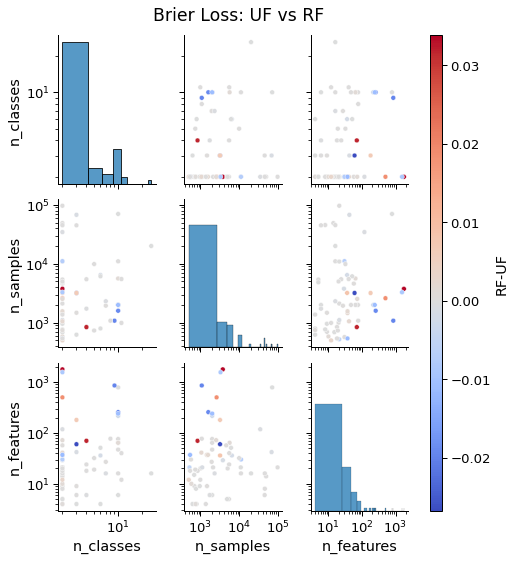

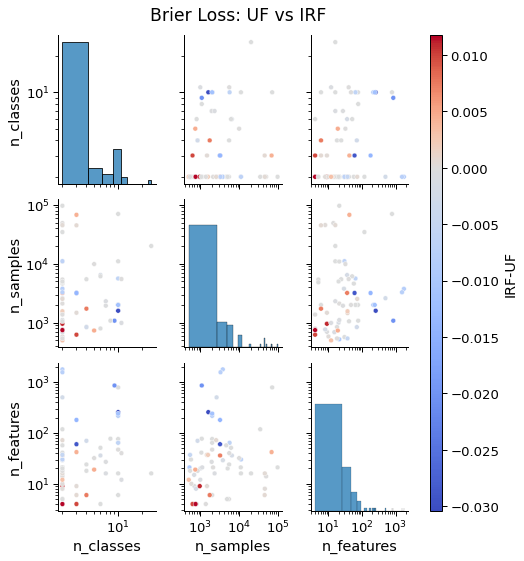

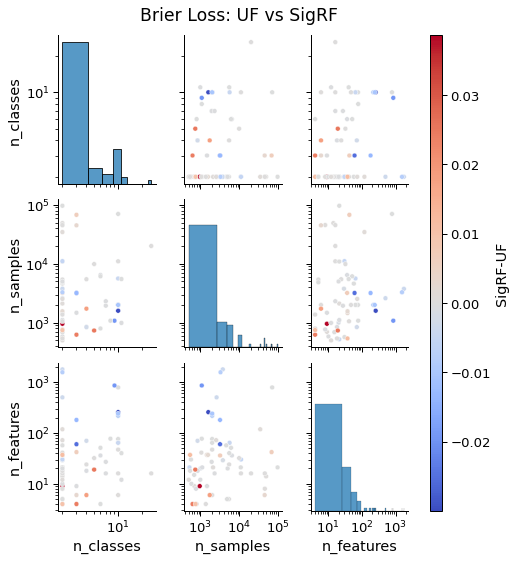

In [26]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'Brier Loss: UF vs {clf}', y=1.03)
    plt.savefig(f'./figures/brier_pairplot_UF-vs-{clf}.pdf')
    plt.show()

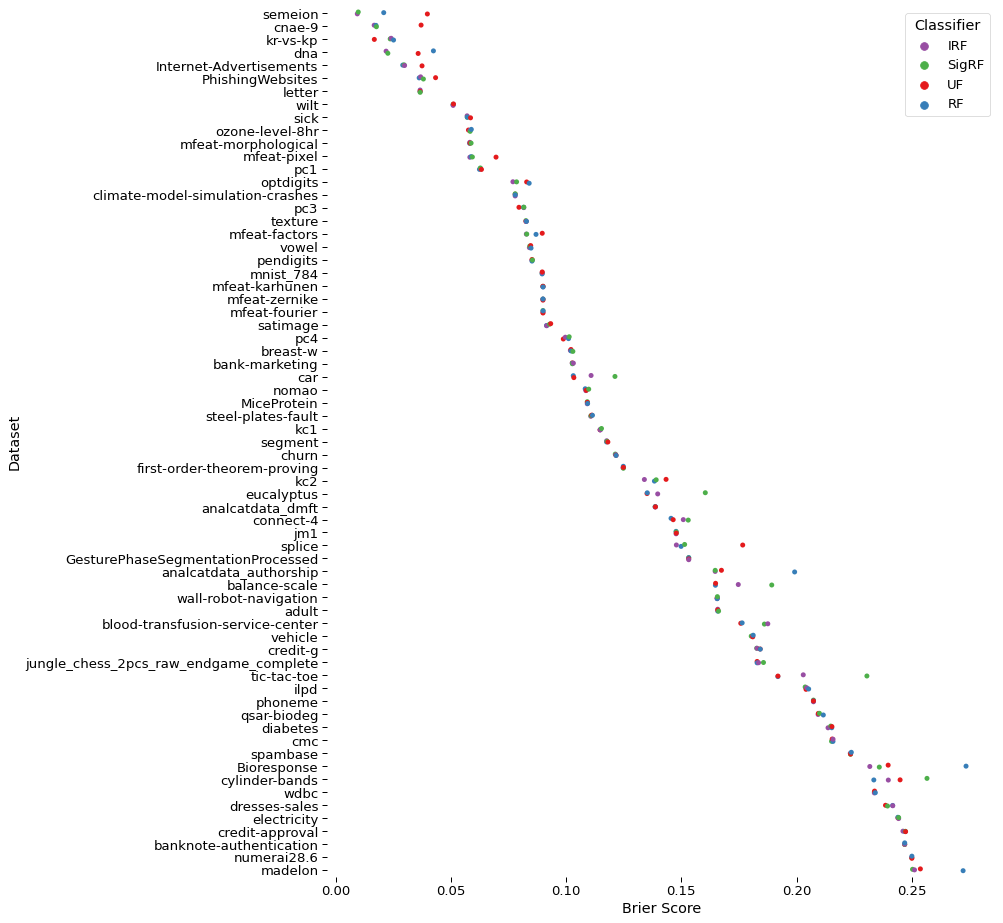

In [28]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='Brier Score'
).sort_values('Brier Score')

# Show each observation with a scatterplot
sns.stripplot(x="Brier Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.savefig(f'./figures/brier_scatterplot.pdf')
plt.show()

## ECE Plots

In [29]:
tasks, task_score_means, task_score_stds = get_task_scores(ece)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [31]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv('./csvs/ece_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,1654.500 (0.999),1408.000 (0.954),1399.500 (0.948)
IRF,623.500 (0.001),,855.000 (0.038),812.000 (0.021)
SigRF,870.000 (0.046),1423.000 (0.962),,899.000 (0.067)
UF,878.500 (0.052),1466.000 (0.979),1379.000 (0.933),


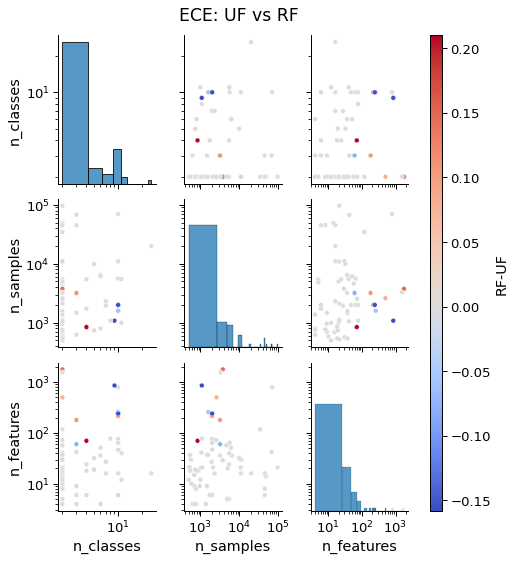

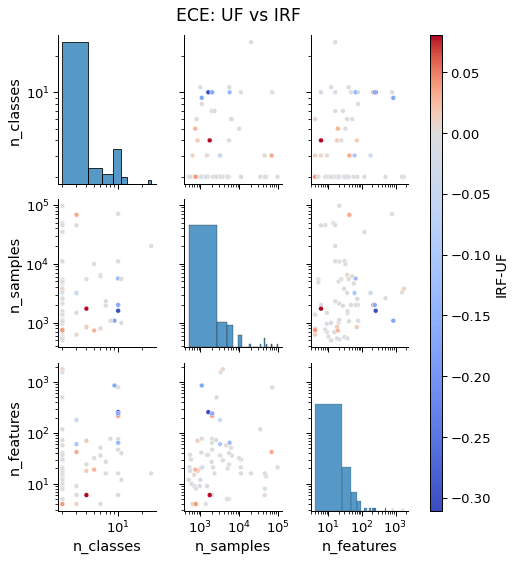

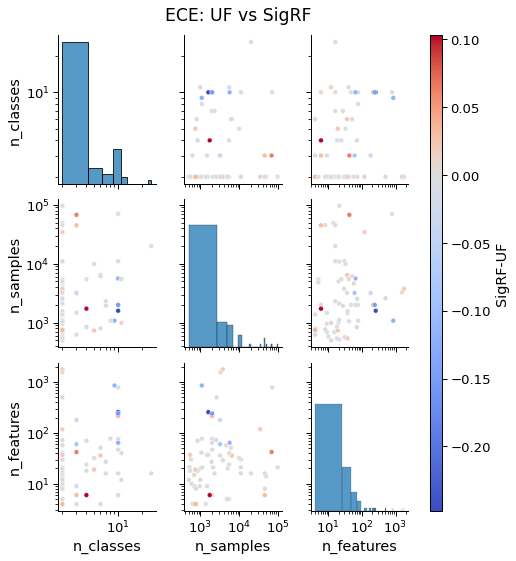

In [30]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'ECE: UF vs {clf}', y=1.03)
    plt.savefig(f'./figures/ece_pairplot_UF-vs-{clf}.pdf')
    plt.show()

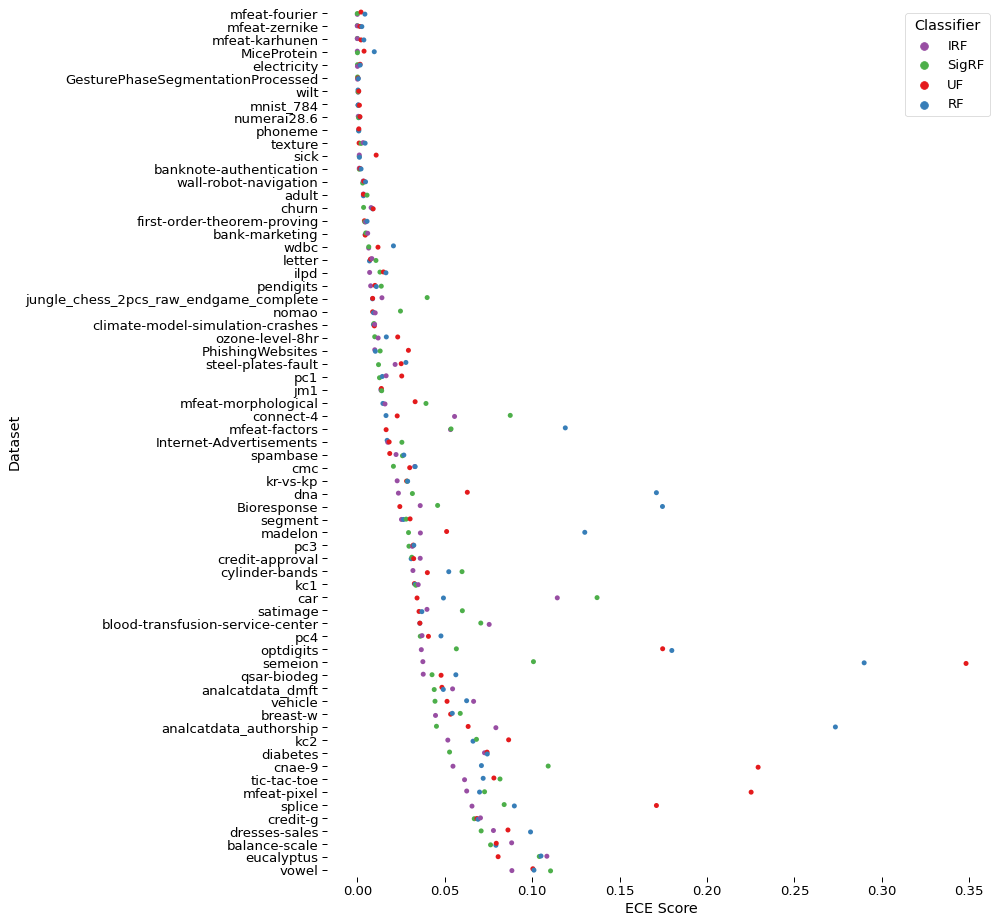

In [33]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('ECE Score')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.savefig(f'./figures/ece_scatterplot.pdf')
plt.show()

## MCE Plots

In [36]:
tasks, task_score_means, task_score_stds = get_task_scores(mce)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [37]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv('./csvs/mce_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,1594.000 (0.998),1458.000 (0.977),1415.000 (0.958)
IRF,684.000 (0.002),,1181.500 (0.605),1187.000 (0.618)
SigRF,820.000 (0.023),1096.500 (0.395),,1057.000 (0.304)
UF,863.000 (0.042),1091.000 (0.382),1221.000 (0.696),


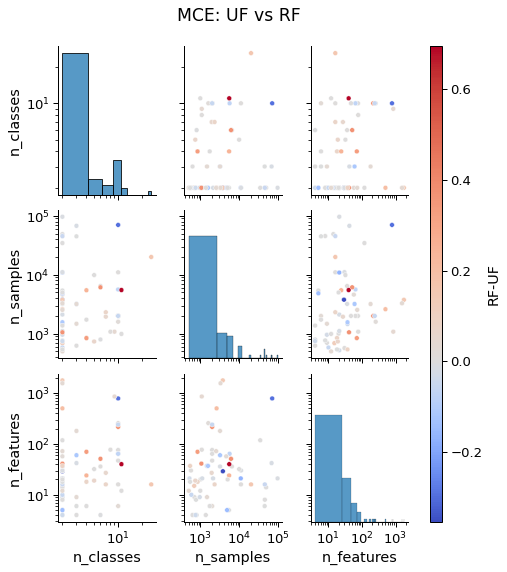

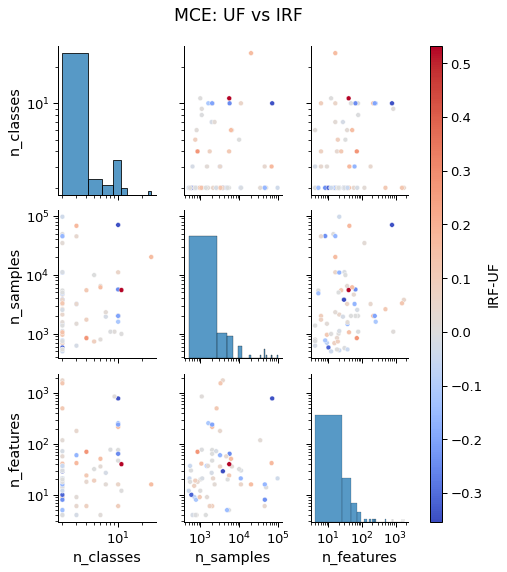

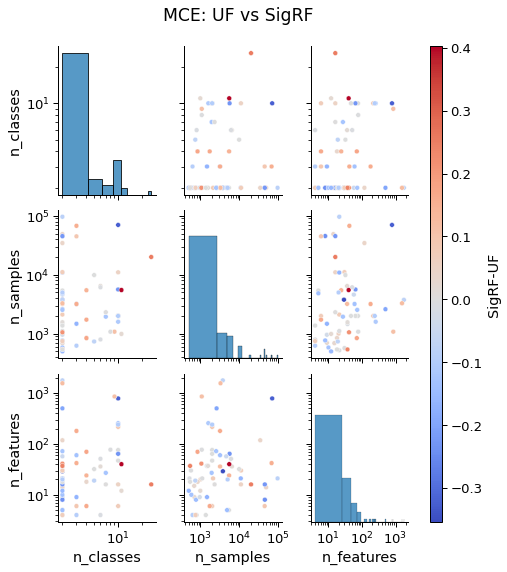

In [38]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'MCE: UF vs {clf}', y=1.05)
    plt.savefig(f'./figures/mce_pairplot_UF-vs-{clf}.pdf')
    plt.show()

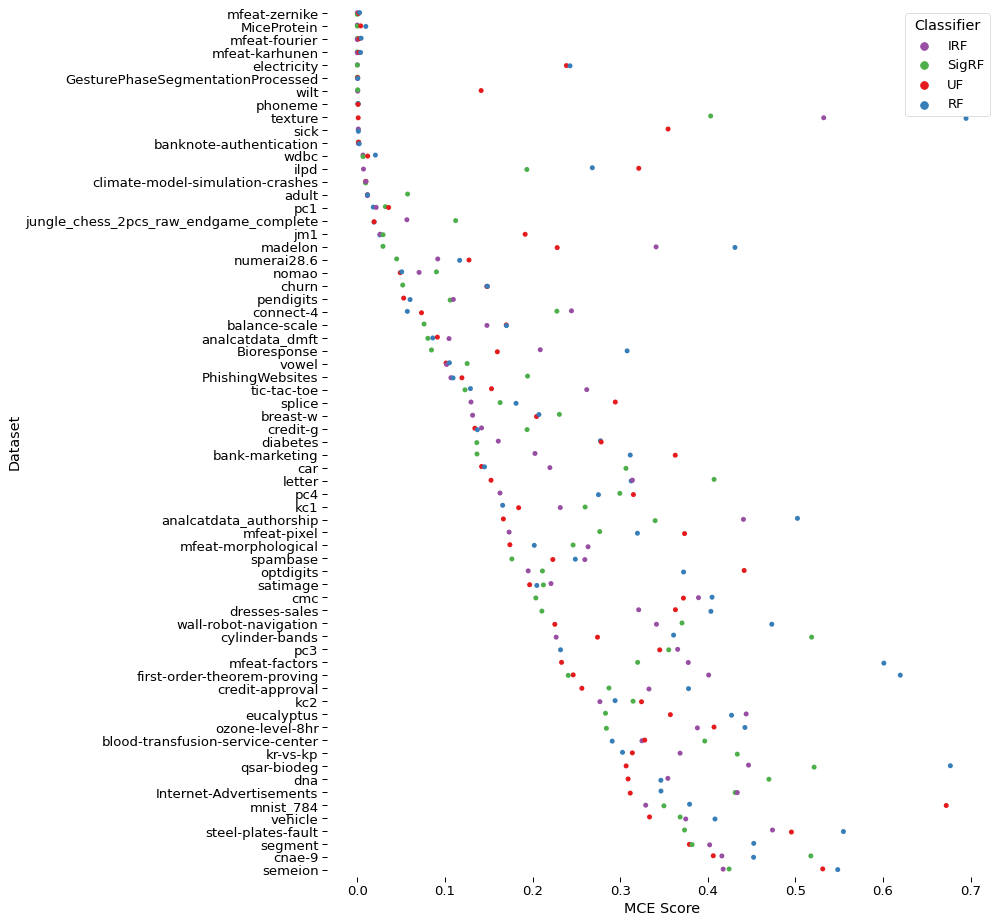

In [39]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='MCE Score'
).sort_values('MCE Score')

# Show each observation with a scatterplot
sns.stripplot(x="MCE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)
plt.savefig(f'./figures/mce_scatterplot.pdf')
plt.show()

## Error

In [56]:
tasks, task_score_means, task_score_stds = get_task_scores(
    lambda y_true, y_proba: zero_one_loss(y_true, y_proba.argmax(1)))

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [57]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv('./csvs/error_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,968.500 (0.142),856.000 (0.038),768.500 (0.010)
IRF,1309.500 (0.858),,983.500 (0.164),852.500 (0.036)
SigRF,1422.000 (0.962),1294.500 (0.836),,1028.000 (0.243)
UF,1509.500 (0.990),1425.500 (0.964),1250.000 (0.757),


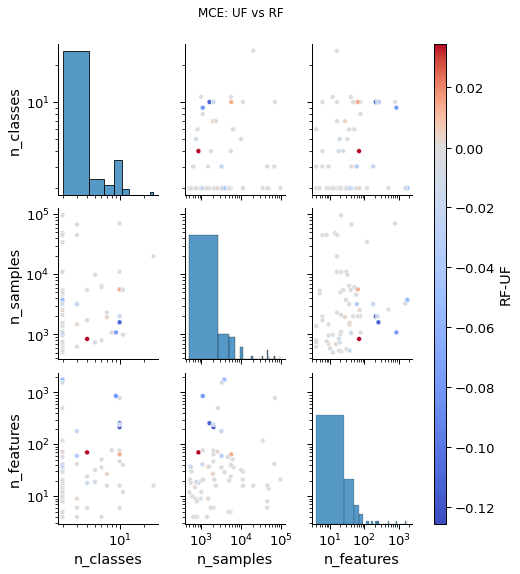

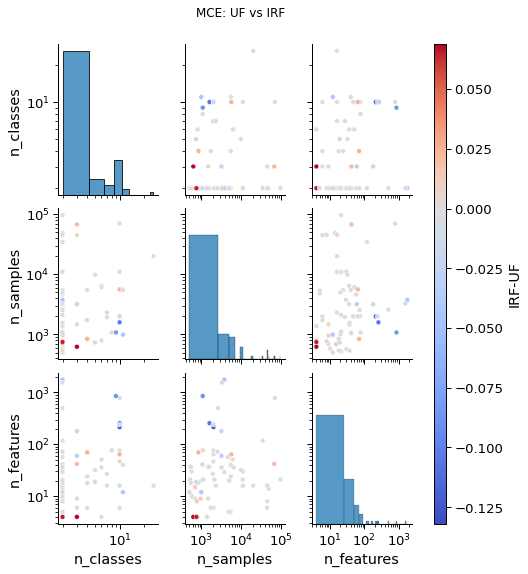

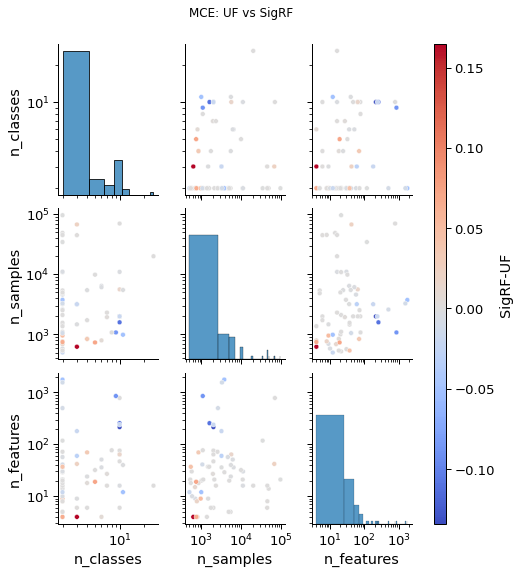

In [49]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'MCE: UF vs {clf}', y=1.05)
    plt.savefig(f'./figures/error_pairplot_UF-vs-{clf}.pdf')
    plt.show()

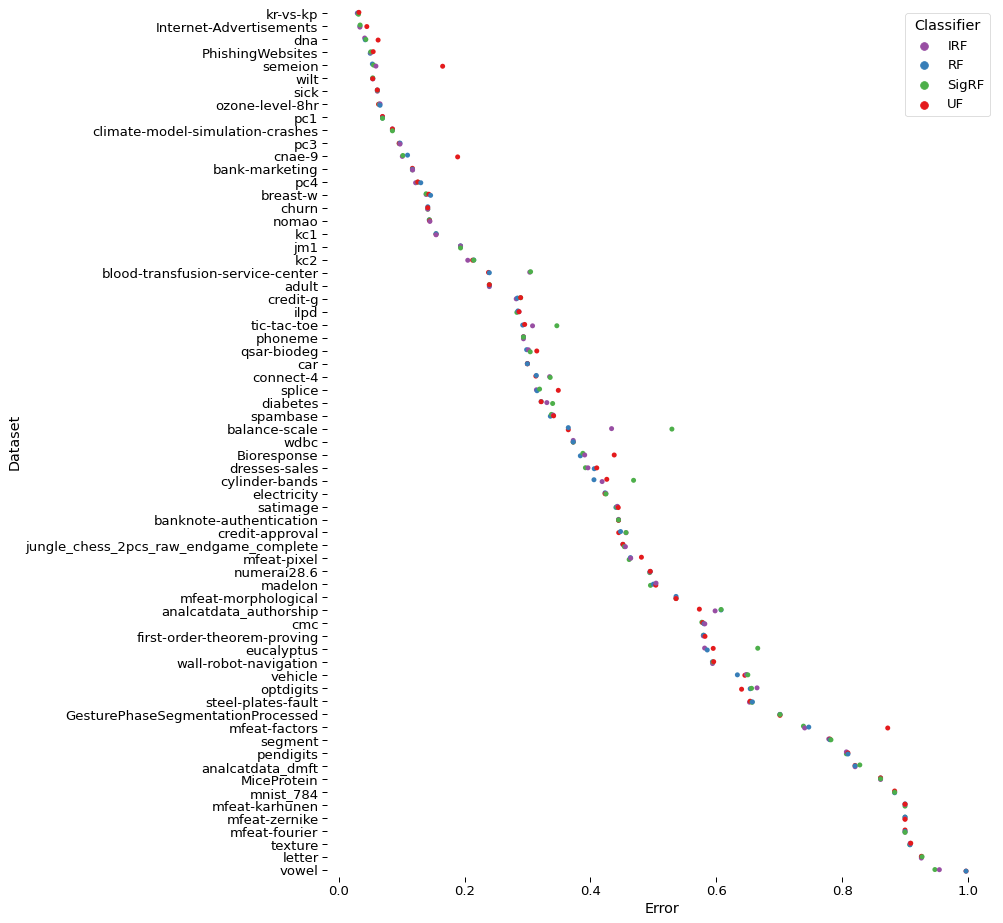

In [50]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='Error'
).sort_values('Error')

# Show each observation with a scatterplot
sns.stripplot(x="Error", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)
plt.savefig(f'./figures/error_scatterplot.pdf')
plt.show()

In [54]:
score_df[score_df['Dataset']=='vowel']

,Dataset,n_classes,n_samples,n_features,RF,IRF,SigRF,UF,RF-UF,IRF-UF,SigRF-UF,UF_diff_max
3022,vowel,11,990,12,0.99697,0.95455,0.94747,0.99697,0.0,-0.04242,-0.0495,0.0
